In [1]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools


# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
!pip install transformers
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.0 MB/s eta 0:00:00


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('drive/MyDrive/NNDL/data.csv',encoding = "ISO-8859-1",engine="python",error_bad_lines=False,names=DATASET_COLUMNS)

In [5]:
# Raw data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df['target'] = df['target'].apply(lambda x: decode_sentiment(x))

CPU times: user 634 ms, sys: 8.74 ms, total: 643 ms
Wall time: 857 ms


In [8]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [9]:
df['target']

0          NEGATIVE
1          NEGATIVE
2          NEGATIVE
3          NEGATIVE
4          NEGATIVE
             ...   
1599995    POSITIVE
1599996    POSITIVE
1599997    POSITIVE
1599998    POSITIVE
1599999    POSITIVE
Name: target, Length: 1600000, dtype: object

Text(0.5, 0.98, 'Distribution of the Tweets')

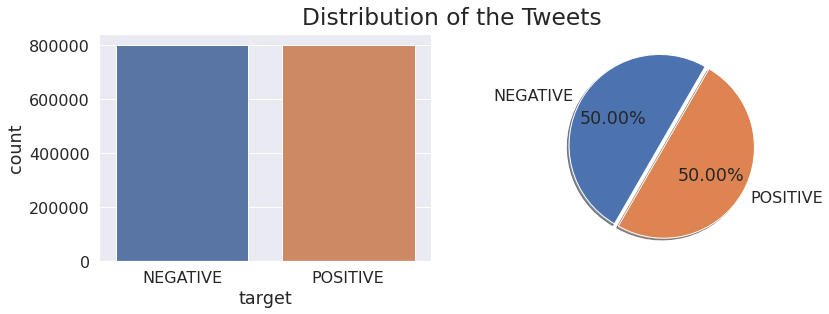

In [10]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(x=df['target'],ax = axes[0]); # shows a count plot refering to the number of 0 and 4 in the column
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)


In [11]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

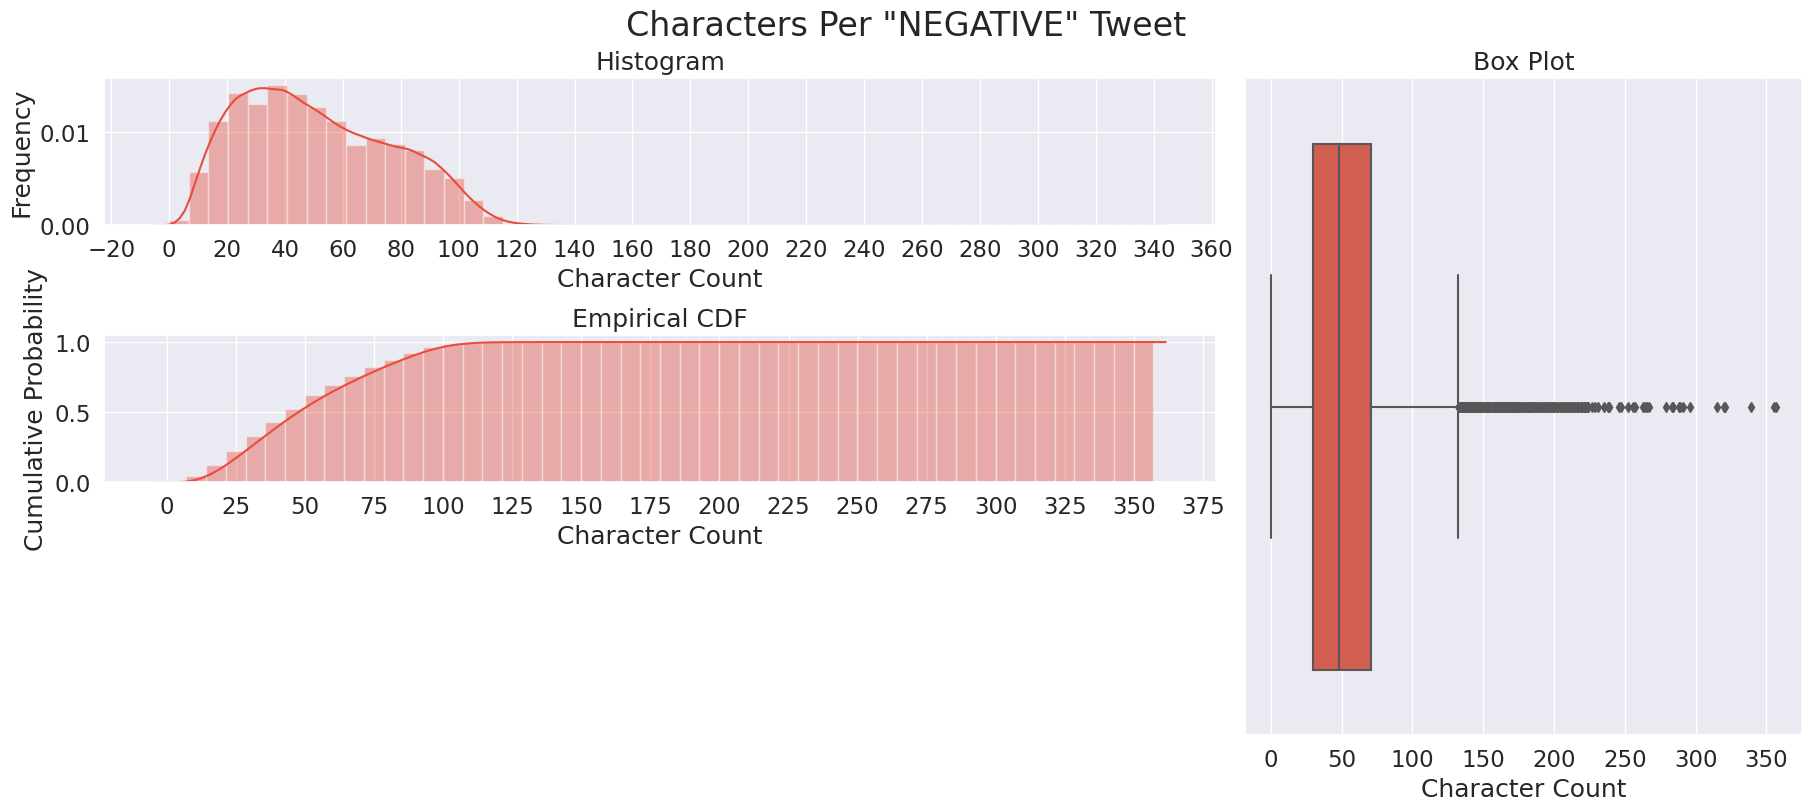

In [12]:
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Tweet')

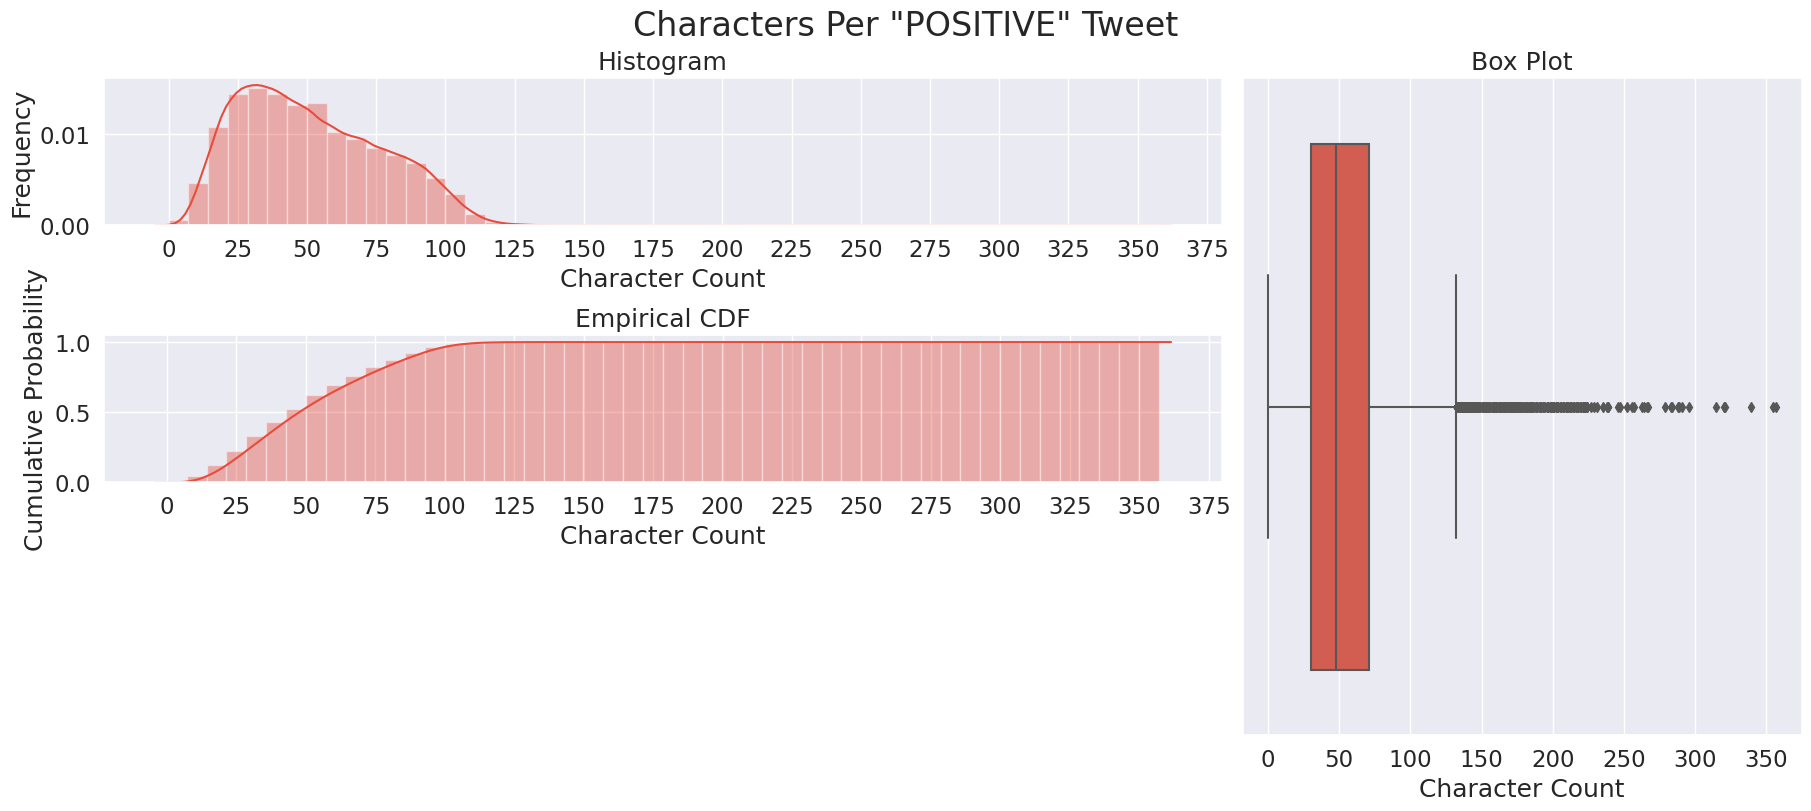

In [13]:
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count',
           'Characters Per "POSITIVE" Tweet')

In [14]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [16]:
# hyperparameters
max_length = 140 # max length of tweets in the dataset collection time
batch_size = 128 # huge batch_size is used because it affects training time significantly. /we have really big dataset/

In [17]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [18]:
train_df, test = train_test_split(df, test_size=0.01, random_state=42)
x_train, dev = train_test_split(train_df, test_size=0.01, random_state=42)

In [19]:
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1568160, 8)
(16000, 8)
(15840, 8)


In [20]:
train = x_train[:500000]

In [21]:
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (500000, 1)
y_test (16000, 1)


In [23]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [24]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

In [25]:
def bert_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
    
    return model

In [26]:
with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

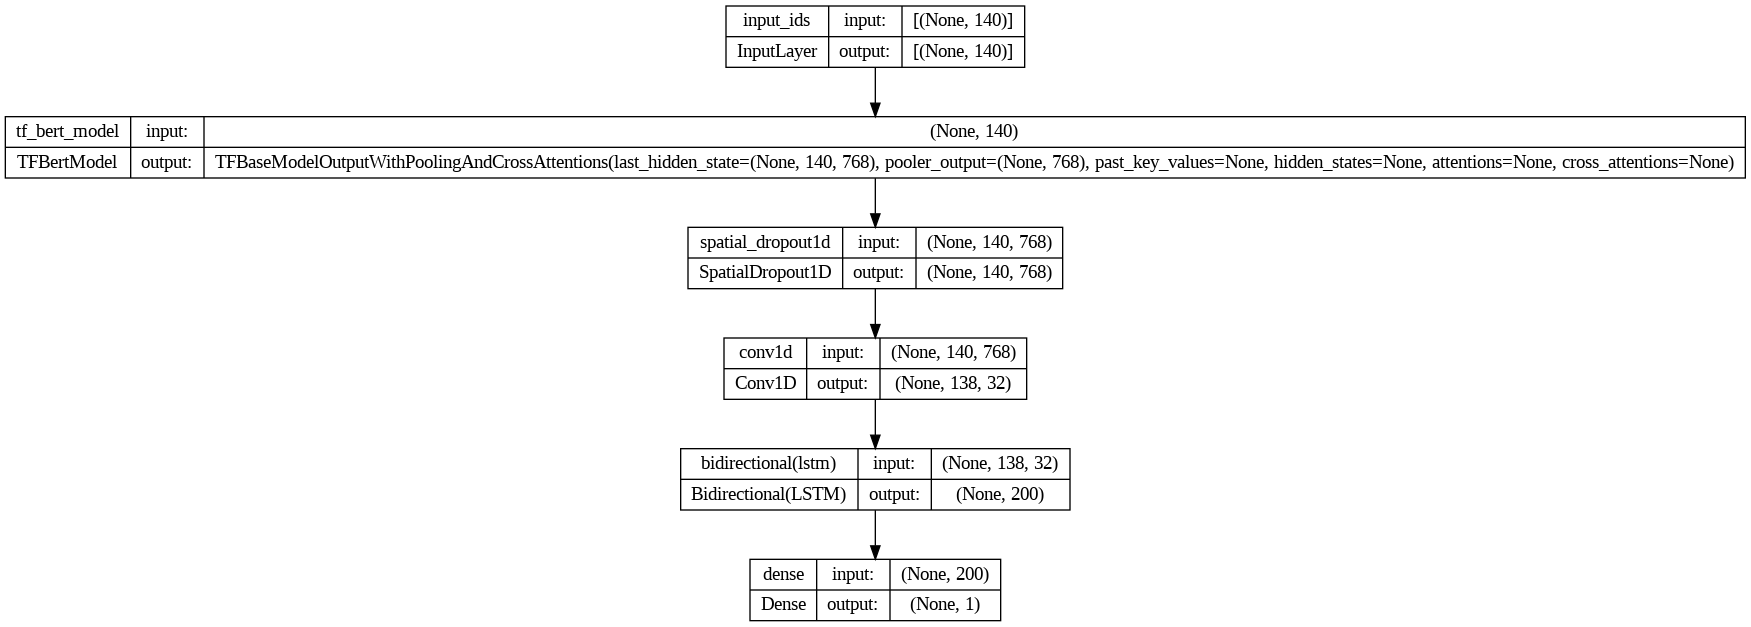

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [30]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/3


ResourceExhaustedError: ignored

In [ ]:
# SAVE MODEL WEIGHTS
model.save_weights(f'sentiment_weights_v1.h5')

In [ ]:
import shutil

shutil.copy("sentiment_weights_v1.h5","/content/drive/MyDrive/NNDL/")

In [ ]:
# LOAD MODEL WEIGHTS
#model.load_weights('../input/-THE PATH THAT YOU UPLOADED WEIGHTS ON KAGGLE-/sentiment_weights_v1.h5')

#to be able to use weights you need to run same model again without fitting because you need model to get weights:) 

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
   
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  